# Use of PSD to represent data

- get PSD function + visualisation 
- import data and prepare dataFrame
- get Train-test_sets
- train AE - get predictions

In [34]:
import numpy as np
import os 
import librosa
import librosa.display
import soundfile as sf
import pandas as pd

from scipy import signal
import matplotlib.pyplot as plt

In [35]:
def import_data(wav_name,channel=4):
    try:
        multi_channel_data, sr = sf.read(wav_name)
        if multi_channel_data.ndim <= 1:
            # ADD HERE A CONDITION TO READ MULTICHANNEL LENGTH AND REMOVE IF TOO SHORT
            return sr, multi_channel_data
        return sr, np.array(multi_channel_data)[:,channel]
    except ValueError:
        pass

In [57]:
def PSD_DF_Maker(user_path,data_path,filenum):
    your_path = user_path+data_path
    files = os.listdir(your_path)
    file = files[filenum]
    if os.path.isfile(os.path.join(your_path,file)):
        fs, audio = import_data(os.path.join(your_path,file))
        f_vec, PSD = signal.welch(audio, fs, nperseg=1024)
    return f_vec,PSD,file

PSD pour data normale

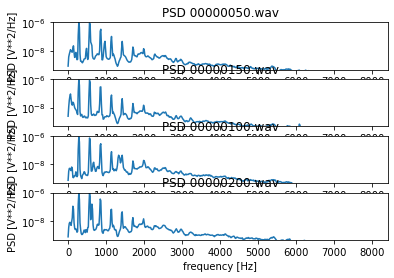

In [84]:
ID = IDs[3]
status = stati[0]
name = names[0]

data_path = folder + name + '/' + ID + '/' + status






plt.show()

#data_name = name +'_' + ID + '_' + status + '.parquet'
#df_spectro.columns=["C"+str(i) for i in range(1, df_spectro.shape[1]+1)]
#df_spectro.to_parquet(writer_path + data_name, index=False) 

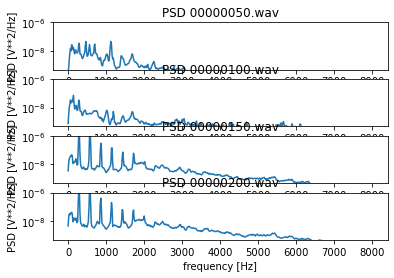

In [93]:
ID = IDs[3]
status = stati[1]
name = names[0]

data_path = folder + name + '/' + ID + '/' + status

#### Multiple plots
plt.figure(1)
plt.subplot(411)
f_vec, Pxx, filename = PSD_DF_Maker(user_path,data_path,50)
plt.semilogy(f_vec, Pxx)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.ylim([0.5e-9, 1e-6])
plt.title('PSD ' + str(filename))


plt.subplot(412)
f_vec, Pxx, filename = PSD_DF_Maker(user_path,data_path,100)
plt.semilogy(f_vec, Pxx)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.ylim([0.5e-9, 1e-6])
plt.title('PSD ' + str(filename))

plt.subplot(413)
f_vec, Pxx, filename = PSD_DF_Maker(user_path,data_path,150)
plt.semilogy(f_vec, Pxx)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.ylim([0.5e-9, 1e-6])
plt.title('PSD ' + str(filename))

plt.subplot(414)
f_vec, Pxx, filename = PSD_DF_Maker(user_path,data_path,200)
plt.semilogy(f_vec, Pxx)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.ylim([0.5e-9, 1e-6])
plt.title('PSD ' + str(filename))


plt.show()

## Feature engineering

Considering different features to interpret for the AE rather than the full PSD might be doable :
- Mean value
- Peaks frequency
- Max peak amplitude

Other than that, the PSD can be cut around 3000 Hz, the frequency content is not interesting above this threshold.

cutting PSD at 3000 Hz

In [94]:
PSD_cut = Pxx[f_vec < 3000]

In [95]:
PSD_cut.shape

(192,)

# Training of AE using PSD

- Gather all PSD onto a dataframe (cut at 3000 Hz)
- Train an autoencoder

In [124]:
def lossCalcMSE(model,data):
    reconstructions = model(tf.cast(data,float))
    return tf.keras.losses.mse(reconstructions,data)

lossValues = lossCalcMSE(autoencoder, test_set)

# __Main__ function

In [ ]:
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
import numpy as np
## import functions
import sys
sys.path.append("..")
from src import Train_test_sets_maker
from src import MinMaxNormalisation
from src import Visualize
from src import MIMII_AE

In [127]:
### Path files
names = ['fan']
stati = ['normal', 'abnormal']
SNR = ['+6dB', '-6dB']

folder = '/MIMII/RawData/' + SNR[0] + '/' # fan/id_00/abnormal'
user_path = 'C:/Users/carbo/Documents/'
writer_path = 'C:/Users/carbo/Documents/MIMII/Data/' + SNR[0] +'/PSD/'

### Parameters
IDs = ['id_00','id_02', 'id_04', 'id_06']

AUCs = []

for ID in IDs:

    # Get data
    ID = IDs[2]
    status = stati[0] # normal
    name = names[0]
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_normal = PSD_DF_Maker(user_path, data_path)

    status = stati[1] # abnormal
    data_path = folder + name + '/' + ID + '/' + status
    df_PSD_abnormal = PSD_DF_Maker(user_path, data_path)

    # Create datasets for training/evaluation
    train_set, test_set, test_labels = Train_test_sets_maker.fun(df_PSD_normal,df_PSD_abnormal)
    # Normalize
    MIN,MAX = MinMaxNormalisation.getMinMax(train_set)
    train_set = MinMaxNormalisation.fun(train_set,MIN,MAX)
    test_set = MinMaxNormalisation.fun(test_set,MIN,MAX)


    # Train algorithm
    autoencoder = MIMII_AE.fun(train_set.shape[1])
    history = autoencoder.fit(train_set, train_set, 
                              epochs=50, 
                              batch_size=512,
                              validation_data=(test_set,test_set),
                              validation_split = 0.1,
                              verbose = 1,
                              shuffle=True
                             )

    lossValues = lossCalcMSE(autoencoder, test_set)
    AUCs.append(metrics.roc_auc_score(~test_labels, lossValues))      

Train & test sets created !
Epoch 1/50
2/2 [==============================] - 1s 130ms/step - loss: 0.0078 - val_loss: 0.0115
Epoch 2/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0072 - val_loss: 0.0110
Epoch 3/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0068 - val_loss: 0.0106
Epoch 4/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0065 - val_loss: 0.0101
Epoch 5/50
2/2 [==============================] - 0s 22ms/step - loss: 0.0061 - val_loss: 0.0096
Epoch 6/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 7/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0053 - val_loss: 0.0083
Epoch 8/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0048 - val_loss: 0.0076
Epoch 9/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0043 - val_loss: 0.0069
Epoch 10/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0038 - val_loss: 0.0063


# Conclusion

The AUCs obtained with the PSD shows that it could be used to detect anomaly in the case of the fan: all IDs have > 0.98 as AUC

In [135]:
import pandas as pd
df_MIMII = 
df_MIMII

,00,02,04,06
0,0.750000,0.990000,0.920000,0.990000
1,0.988175,0.987779,0.986937,0.993245


In [139]:
np.mean(AUCs)

0.9890342185229224